In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Grayscale, Compose

import numpy as np
import matplotlib.pyplot as plt

This dataset are downloaded through PyTorch. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. To make the prediction easier, I downloaded the grayscale of the image and convert the image data into numerical values.

In [2]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose([Grayscale(),ToTensor()])
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose([Grayscale(),ToTensor()])
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [4]:
testing_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [5]:
training_data[0]

(tensor([[[0.2392, 0.1725, 0.1882,  ..., 0.5373, 0.5098, 0.5020],
          [0.0706, 0.0000, 0.0392,  ..., 0.3686, 0.3529, 0.3686],
          [0.0902, 0.0314, 0.1216,  ..., 0.3529, 0.3529, 0.3137],
          ...,
          [0.6745, 0.6000, 0.6118,  ..., 0.5216, 0.1373, 0.1490],
          [0.5725, 0.5020, 0.5608,  ..., 0.5961, 0.2706, 0.2314],
          [0.5882, 0.5333, 0.5725,  ..., 0.7373, 0.4824, 0.3843]]]), 6)

Each instance (image) in the dataset is a 32x32 tensor matrix. To training this data, I define each pixel as one feature of each instance. Then the first step is to flatten the matrix to vector, so that each instance has 1024 features. I only used 10% of the training and testing data so the model will not run too long time. 

In [6]:
training_sample = np.array([x_train[0].numpy().flatten() for x_train in training_data])
testing_sample = np.array([x_test[0].numpy().flatten() for x_test in testing_data])

training_sample_5k = training_sample[:5000]
testing_sample_1k = testing_sample[:1000]

print(training_sample_5k.shape)
print(testing_sample_1k.shape)

(5000, 1024)
(1000, 1024)


The label of this dataset contains 10 classes, so the neural network model of this dataset will have 10 nodes in output layer. 

In [7]:
training_label = np.array([y_train[-1] for y_train in training_data])
testing_label = np.array([y_test[-1] for y_test in testing_data])

training_label_5k = training_label[:5000]
testing_label_1k = testing_label[:1000]

print(training_label_5k.shape)
print(testing_label_1k.shape)

(5000,)
(1000,)


# Create possible active functionsand direvatives

In [8]:
def sigmoid(x):  
    return 1/(1 + np.exp(-x))

def sigmoid_d(x):
    return sigmoid(x) * (1-sigmoid(x))

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def tanh_d(x):
    return 1 - tanh(x)**2

def relu(x):
    return np.maximum(0,x)

def relu_d(x):
    x[x<0] = 0
    x[x>=0] = 1
    return x


def softmax(x):
    exp = np.exp(x)
    scores = exp / exp.sum(axis=1, keepdims=True)
    
    return scores

# First randomly initialize weights and bias

In [9]:
def initialization(num_input, num_hidden, num_output):
    parameters = {}
    
    parameters['weight_hidden'] = np.random.rand(num_input,num_hidden)
    parameters['weight_output'] = np.random.rand(num_hidden,num_output)
    
    parameters['bias_hidden'] = np.zeros((1, num_hidden))
    parameters['bias_output'] = np.zeros((1, num_output))
    
    return parameters

# Define forward propagation

In [10]:
def activate(f, activation):
    if activation == 'sigmoid':
        a = sigmoid(f)
    elif activation == 'tanh':
        a = tanh(f)
    elif activation == 'relu':
        a = relu(f)
        
    return a

In [11]:
def activate_derivative(f, activation):
    if activation == 'sigmoid':
        a_d = sigmoid_d(f)
    elif activation == 'tanh':
        a_d = tanh_d(f)
    elif activation == 'relu':
        a_d = relu_d(f)

    return a_d

For this dataset, I want to define a model that use same activation funciton on hidden layer and output layer

In [12]:
def forward(x, parameters, activation):
    predict = {}
    
    predict['input_hidden'] = np.dot(x, parameters['weight_hidden']) + parameters['bias_hidden']
    predict['output_hidden'] = activate(predict['input_hidden'], activation)
        
    predict['input_output'] = np.dot(predict['output_hidden'], parameters['weight_output']) + parameters['bias_output']
    predict['predict_y'] = activate(predict['input_output'], activation)
    
    return predict

# Define Backpropagation

This is a simple model that only contains one hidden layer

In [13]:
def backpropagation(x, y, parameters, predict, learning_rate, activation):

    # weight and bias update on output layer
    diff = predict['predict_y'] - y
    activate_dout = activate_derivative(predict['input_output'],activation)
    dw_output = np.dot(predict['output_hidden'].T, activate_dout* diff)
    db_output = np.sum(activate_dout*diff, axis=0,keepdims=True)
    
    # weight and bias update on hidden layer
    p2 = np.dot(diff * activate_dout,parameters['weight_output'].T)
    activate_dhidden = activate_derivative(predict['input_hidden'],activation)
    dw_hidden = np.dot(x.T, activate_dhidden * p2)
    db_hidden = np.sum(p2*activate_dhidden, axis=0,keepdims=True)
    
    parameters['weight_hidden'] -= learning_rate * dw_hidden
    parameters['weight_output'] -= learning_rate * dw_output
    parameters['bias_hidden'] -= learning_rate * db_hidden
    parameters['bias_output'] -= learning_rate * db_output
    
    return parameters

# Generate neural network model

Now create the neural network model. For this model, I used Mean Square Error (MSE) as the cost funciton

MSE: $\dfrac{1}{2m} \sum^{m}_{1} (\hat{Y} - Y)^{2}$

derivative of MSE: $\hat{Y} - Y$


In [14]:
def NN_model(x, y, hidden_width, activation, learning_rate, epochs):
    parameter = initialization(x.shape[1], hidden_width, y.shape[1])
#     parameter = initialization(x.shape[1], hidden_width, 1)
    MSE = []
    for epoch in range(epochs):
        
        prediction = forward(x,parameter,activation)
        
        mse = ((1/2) * np.power((prediction['predict_y'] - y),2)).mean()
        MSE.append(mse)

        parameter = backpropagation(x, y, parameter, prediction, learning_rate, activation)
        
        if epoch % 1000 == 0:
            print("After %d epochs, MSE is now: %f" % (epoch, mse))
        
    return parameter, prediction, MSE

# Make prediction on testing data and calculate accuracy

In [15]:
def predict_model(x, y, parameter, hidden_width, activation):
    prediction = forward(x, parameter, activation)
    
    predict_y = np.argmax(prediction['predict_y'],axis=1)
    y_label = np.argmax(y,axis=1)
    correct_predictions = np.sum(predict_y == y_label)
    accuracy = correct_predictions / len(y_label)
    return accuracy
    

In [16]:
import pandas as pd
label_training = np.array(pd.get_dummies(training_label_5k))

label_training.shape

(5000, 10)

After 0 epochs, MSE is now: 0.449840
After 1000 epochs, MSE is now: 0.287873
After 2000 epochs, MSE is now: 0.167461
After 3000 epochs, MSE is now: 0.167456
After 4000 epochs, MSE is now: 0.167319
After 5000 epochs, MSE is now: 0.126239
After 6000 epochs, MSE is now: 0.126235
After 7000 epochs, MSE is now: 0.126116
After 8000 epochs, MSE is now: 0.085526
After 9000 epochs, MSE is now: 0.085525


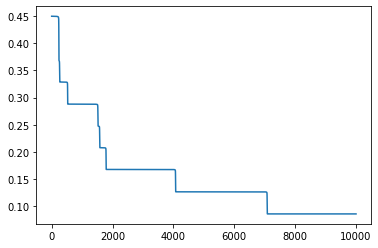

In [17]:
parameter,prediction,MSE = NN_model(training_sample_5k, label_training, 20, 'sigmoid', 0.0001, 10000)
x = np.arange(0,10000)
plt.figure()
plt.plot(x,MSE)
plt.show()

In [18]:
label_testing = np.array(pd.get_dummies(testing_label_1k))

accuracy = predict_model(testing_sample_1k, label_testing, parameter, 20, 'sigmoid')
print("The prediction accuracy is: %f" % accuracy)

The prediction accuracy is: 0.109000


For this prediction model, Since the dataset contains large number of features, so it takes longer time to training the data. The cost plot also shows that the cost value is reduced during the training. But event the meas square error at the end is remains small, but the accuracy is much lower than the model for Abalone dataset. And this dataset contains more feature and more classes, which may proved my assumption that when we have more complex data (large number of features and multiple classifications), we need to have a complex model to increase the accuracy, eg. more hidden layer and more nodes in each hidden layer.